In [1]:
# Copyright 2025 Quantinuum (www.quantinuum.com)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Setup

## Imports

In [2]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import binom, norm
import tabulate

## Plot Style

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'

## Helper Functions

In [4]:
ONE_SIGMA_CONF_LEVEL = 1 - 2 * norm.cdf(-1)  # 0.6827...

@np.vectorize
def get_binomial_error_bars(
    num_success: int,
    num_trials: int,
) -> tuple[float, float]:
    """
    Return the Wilson-Score error bars for a binomial process
    """
    alpha = 1 - ONE_SIGMA_CONF_LEVEL
    z = norm.ppf(1 - alpha / 2)

    p = num_success / num_trials
    n = num_trials

    center = (1 / (1 + z**2 / n)) * (p + z**2 / (2 * n))
    confidence_span = (z / (1 + z**2 / n)) * np.sqrt(
        p * (1 - p) / n + z**2 / (4 * n**2)
    )

    conf_region_lower_bound = center - confidence_span
    conf_region_upper_bound = center + confidence_span

    lower_err = p - conf_region_lower_bound
    upper_err = conf_region_upper_bound - p

    return lower_err, upper_err


def mcmc_conf_intervals(
    flat_result_samples,
    center_vals,
):
    """
    Calculate the minimal 1-sigma confidence intervals around the best fit parameters given
    a collection of MCMC samples for some likelihood function.

    This function works by stepping through a range of possible confidence intervals given
    the samples and selecting the intervals which contain the fit parameters and have the
    correct coverage.
    """
    conf_level = ONE_SIGMA_CONF_LEVEL
    conf_intervals = []
    for idx, val in enumerate(center_vals):
        param_samples = flat_result_samples[:, idx]
        conf_lower = min(param_samples)
        conf_upper = max(param_samples)
        min_width = np.inf
        for low_p in np.linspace(0, 1 - ONE_SIGMA_CONF_LEVEL, 1000):
            low_val, high_val = np.quantile(param_samples, (low_p, low_p + conf_level))
            width = high_val - low_val
            if width < min_width:
                min_width = width
                conf_lower = low_val
                conf_upper = high_val
        conf_intervals.append((conf_lower, conf_upper))

    return conf_intervals



# The Data

In [ ]:
reps_list = np.array([0,2,4,6,8])
num_trials_list = np.array([29206, 7577, 5492, 4287, 3036])
num_success_list = np.array([29205, 7576, 5490, 4284, 3032])

success_fraction_list =  num_success_list / num_trials_list
err_lower, err_upper = get_binomial_error_bars(num_success_list, num_trials_list)

fig, ax = plt.subplots(1, 1)

ax.errorbar(reps_list, success_fraction_list, [err_lower, err_upper], marker='o', color='k', linestyle='')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Survival Rate')
ax.set_title('Survival Rate vs Sequence Length')
plt.show()

## Model and Likelihood Functions

In [6]:
def decay_fit_func(x, s, e):
    return 0.5 + (0.5 - s) * ((1 - 2 * e)**x)

def log_likelihood_func(p):
    """
    Log likelihood function for the fit parameters a, b given the observed data.
    """
    s, e = p

    # These are bounds on the fit parameters
    if not (0 <= s <= 0.25) or not (0 <= e <= 0.25):
        return -np.inf
    
    prob_list = decay_fit_func(reps_list, s, e)
    log_likelihood = np.sum(binom.logpmf(num_success_list, num_trials_list, prob_list))
    return log_likelihood

# We need the negative of the log-likelihood function for use with scipy.minimize. 
# Minimizing the negative of the log-likelihood corresponds to maximizing the log-likelihood.
def neg_log_likelihood_func(p):
    return -log_likelihood_func(p)

# Maximum Likelihood Estimation

In [7]:
minimize_result = minimize(
    fun=neg_log_likelihood_func,
    x0=(500e-4, 200e-4),
    method="Nelder-Mead",
)
s_fit, e_fit = minimize_result.x

# MCMC Sampling

In [8]:
num_walkers = 10
num_dims = 2
num_steps = 1000
num_burn_in_steps = 100

sampler = emcee.EnsembleSampler(num_walkers, num_dims, log_likelihood_func)

init_walkers_array = np.array([s_fit, e_fit]) + 1e-5 * np.random.randn(10, 2)  # Walker initialized with small random variation
state = sampler.run_mcmc(init_walkers_array, num_steps + num_burn_in_steps, progress=True)

samples = sampler.get_chain(discard=num_burn_in_steps)
flat_samples = samples.reshape((num_steps * num_walkers, num_dims))

You must install the tqdm library to use progress indicators with emcee


# Plot MLE Result and MCMC Samples

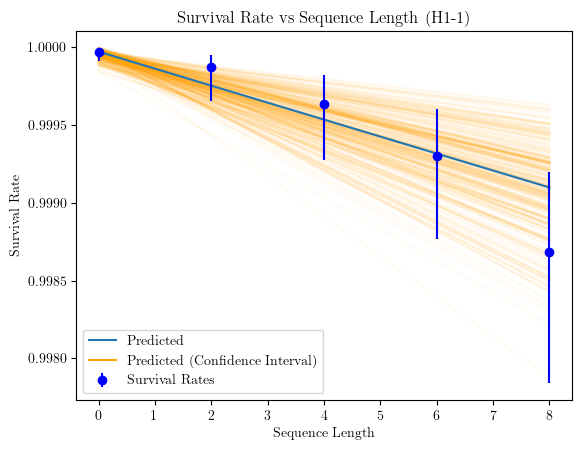

In [9]:
sample_idxs_to_plot = np.random.randint(num_steps, size=300)

fig, ax = plt.subplots(1, 1)

model_x = np.linspace(min(reps_list), max(reps_list), 20 * len(reps_list))

for idx in sample_idxs_to_plot:
    s_plot, e_plot = flat_samples[idx, :]
    sample_model_y = decay_fit_func(model_x, s_plot, e_plot)
    ax.plot(model_x, sample_model_y, color="orange", alpha=0.05)

fit_model_y = decay_fit_func(model_x, s_fit, e_fit)
ax.plot(model_x, fit_model_y, label = 'Predicted')

ax.errorbar(reps_list, success_fraction_list, [err_lower, err_upper], marker='o', linestyle='', color='b', label = 'Survival Rates')

ax.plot([], [], color="orange", label = 'Predicted (Confidence Interval)')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Survival Rate')
ax.set_title('Survival Rate vs Sequence Length (H1-1)')
plt.legend()
plt.show()

# Confidence Intervals

### Calculate Confidence Intervals

In [10]:
conf_intervals = mcmc_conf_intervals(flat_samples, [s_fit, e_fit])

## Print Fit Results

In [11]:
results_table = [
    ['Fit Parameter', 'Fit Value', 'Confidence Interval'],
    ['s', f"{s_fit:.2e}", f"({conf_intervals[0][0]:.2e}, {conf_intervals[0][1]:.2e})"],
    ['e', f"{e_fit:.2e}", f"({conf_intervals[1][0]:.2e}, {conf_intervals[1][1]:.2e})"],
    # ['b', f"{b_fit:.2e}", conf_intervals[1]],
]

print(tabulate.tabulate(results_table, headers='firstrow', tablefmt='simple_grid', disable_numparse=True))

┌─────────────────┬─────────────┬───────────────────────┐
│ Fit Parameter   │ Fit Value   │ Confidence Interval   │
├─────────────────┼─────────────┼───────────────────────┤
│ s               │ 3.09e-05    │ (1.12e-05, 7.51e-05)  │
├─────────────────┼─────────────┼───────────────────────┤
│ e               │ 1.09e-04    │ (7.16e-05, 1.46e-04)  │
└─────────────────┴─────────────┴───────────────────────┘


In [13]:
# This is another version of the results table using the "sciform" package for scientific number formatting.

from sciform import SciNum, GlobalOptionsContext

with GlobalOptionsContext(exp_mode='engineering', exp_format='parts_per', round_mode='sig_fig', ndigits=3):
    results_table = [
        ['Fit Parameter', 'Fit Value', 'Confidence Interval'],
        ['s', f"{SciNum(s_fit)}", f"({SciNum(conf_intervals[0][0])}, {SciNum(conf_intervals[0][1])})"],
        ['e', f"{SciNum(e_fit)}", f"({SciNum(conf_intervals[1][0])}, {SciNum(conf_intervals[1][1])})"],
    ]

print(tabulate.tabulate(results_table, headers='firstrow', tablefmt='simple_grid', disable_numparse=True))

┌─────────────────┬─────────────┬───────────────────────┐
│ Fit Parameter   │ Fit Value   │ Confidence Interval   │
├─────────────────┼─────────────┼───────────────────────┤
│ s               │ 30.9 ppm    │ (8.37 ppm, 76.4 ppm)  │
├─────────────────┼─────────────┼───────────────────────┤
│ e               │ 109 ppm     │ (76.4 ppm, 152 ppm)   │
└─────────────────┴─────────────┴───────────────────────┘


## Corner Plot to Visualize Confidence Region, Confidence Intervals, and Parameter Correlations

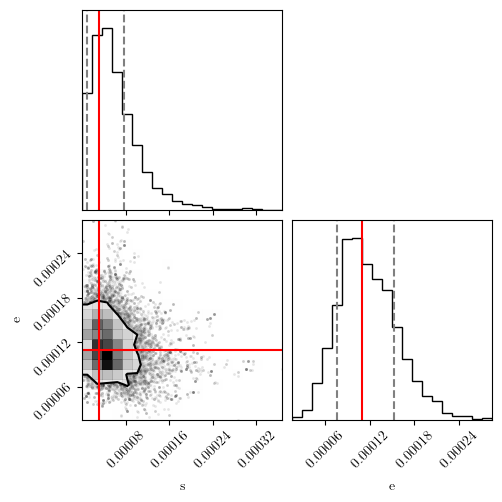

In [14]:
import corner

fig = corner.corner(
    data=flat_samples,
    labels=["s", "e"], levels=[ONE_SIGMA_CONF_LEVEL,]
)
corner.overplot_lines(
    fig=fig,
    xs=(s_fit, e_fit),
    color="red",
)

axes = np.array(fig.axes).reshape((2, 2))

for idx, (conf_lower, conf_upper) in enumerate(conf_intervals):
    ax = axes[idx, idx]
    ax.axvline(conf_lower, linestyle='--', color='grey')
    ax.axvline(conf_upper, linestyle='--', color='grey')

plt.show()

Applying scaling factor to epsilon to get average gate infidelity and confidence interval

In [15]:
print((2/3)*1.1e-04, (2/3)*(7.6e-05), (2/3)*1.5e-04)

7.333333333333333e-05 5.066666666666667e-05 9.999999999999999e-05
